In [1]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys

sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [5]:
#lt = gpd.read_file("/projects/2023_lightning_data/englnrt_20230530_daily_v1_lit.raw")
# lt = pd.read_csv("/projects/2023_lightning_data/englnrt_20230530_daily_v1_lit.raw", names =["InterCloud",
#                                                                                              "t", 
#                                                                                              "lat", 
#                                                                                              "lon",
#                                                                                              "current_mag", 
#                                                                                              "multiplicity_0", 
#                                                                                              "accr", 
#                                                                                              "error_elps", 
#                                                                                              "num_station"])

#lt = pd.read_parquet(path = "/projects/2023_lightning_data/englnrt_20230530_daily_v1_lit.raw")
#?pd.read_parquet

In [7]:
#?pd.read_csv

In [2]:
#?gpd.read_file
#?pd.read_csv

In [3]:
#lt =  gpd.GeoDataFrame(lt, geometry=gpd.points_from_xy(lt['lon'], lt['lat']))

In [4]:
#lt.t = lt.t.astype("datetime64[ns]")

In [5]:
#lt = lt[lt.InterCloud == 0]

In [6]:
### Too many points to plot. Cheat by chopping up the lat and lon readings? 

# lt.lat_r = lt.lat.round(2)
# lt.lon_r = lt.lon.round(2)

In [7]:
# sm = lt[["InterCloud", "lat_r", "lon_r"]]
# sm = sm.drop_duplicates()
# sm = gpd.GeoDataFrame(sm, 
#                       geometry=gpd.points_from_xy(sm['lon_r'], sm['lat_r']))

In [8]:
# print(len(lt))
# len(sm)

# sm.set_crs("4326")

In [9]:
# smol = sm.geometry.sample(100)
# smol = smol.set_crs("epsg:4326")

In [10]:

# plt.figure()
# ax = plt.subplot()
# plot = smol.plot(ax = ax)
# cx.add_basemap(plot, crs=smol.crs.to_string(), attribution = False) 

In [11]:
# ### Subset to canada, using our boreal bbox
# from shapely.geometry import box

    
    
    

# CA_bbox = box(-169, 44, -48, 75)
# lt = lt.set_crs("epsg:4326")

# smol = lt.clip(CA_bbox)

In [12]:
# smol = smol.set_crs("epsg:4326")

# plt.figure()
# ax = plt.subplot()
# plot = smol.plot(ax = ax, alpha=0.2)
# cx.add_basemap(plot, crs=smol.crs.to_string(), attribution = False) ## Projection issues??

In [13]:
# smol.t = smol.t.astype("str")
# #smol.explore()

In [2]:
#df = pd.read_csv('example.csv')
#df.to_parquet('output.parquet')
#?pd.read_parquet

# import sys
# import pandas as pd
# import geopandas as gpd
# import dask.dataframe as dd
# import dask_geopandas

In [30]:
### Try to make a low-memory conversion



import pyarrow as pa
import pyarrow.parquet as pq

new_schema = pa.schema([
    ('InterCloud', pa.int64()),
    ('t', pa.string()),
    ('lat', pa.float64()),
    ('lon', pa.float64()),
    ("current_mag", pa.float64()),
    ("multiplicity_0", pa.int64()),
    ("accr", pa.float64()),
    ("error_elps", pa.float64()),
    ("num_station", pa.float64())
    
])

csv_column_list = ["InterCloud", "t", "lat", "lon", "current_mag", "multiplicity_0", "accr", 
                   "error_elps", 
                   "num_station"]

csvs_regex = '/projects/2023_lightning_data/e*.raw'

In [31]:
import re

#files2 = glob.glob("/projects/2023_lightning_data/e*")
files2 = glob.glob("/projects/2023_lightning_data/englnrt_20230727_daily_v1_lit.raw")
files  = pd.DataFrame(files2)
#names = replace("/projects/2023_lightning_data/", "")  
names = files[0].str.replace("/projects/2023_lightning_data/", "") 
names = names.str.replace(".raw", "")
#re.split(by = "/", files)
#?re.split

#names


/tmp/ipykernel_155/4237181457.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace(".raw", "")


In [32]:
for f,n in zip(files2, names):
    print(f)
    with pq.ParquetWriter('/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/parrow_parquet/' + n + '.parquet', schema=new_schema) as writer:
        with pd.read_csv(f, header=None, names=csv_column_list, chunksize=100000) as reader:
    #with dd.read_csv(csvs_regex, header=None, names=csv_column_list) as reader:
            for df in reader:
                # transformation: transform df by adding a new static column with column name 'newcol' and value 9999999
                # convert pandas df to record batch
                transformed_batch = pa.RecordBatch.from_pandas(df, schema=new_schema)
                writer.write_batch(transformed_batch) 

 

/projects/2023_lightning_data/englnrt_20230727_daily_v1_lit.raw


In [27]:
def get_ca_lt(date, chunk_size, bbox = [-169, 44, -48, 75]): #[-169, 44, -48, 75] [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
    CA_bbox = box(bbox[0], bbox[1], bbox[2], bbox[3])
    print(date)
    
    #lt = pd.read_csv("/projects/my-public-bucket/Lighting_data/2023/englnrt_"+ date+"_daily_v1_lit.raw", names =["InterCloud",
    lt = pd.read_csv("/projects/2023_lightning_data/englnrt_"+ date+"_daily_v1_lit.raw", names =["InterCloud",
                                                                                             "t", 
                                                                                             "lat", 
                                                                                             "lon",
                                                                                             "current_mag", 
                                                                                             "multiplicity_0", 
                                                                                             "accr", 
                                                                                             "error_elps", 
                                                                                             "num_station"], chunksize = chunk_size)
    
    lt = list(lt) #pd.concat(tp, ignore_index=True)
    lt =  gpd.GeoDataFrame(lt, geometry=gpd.points_from_xy(lt['lon'], lt['lat']))
    lt.t = lt.t.astype("datetime64[ns]")
    lt = lt[lt.InterCloud == 0]
    lt = lt.set_crs("epsg:4326")
    smol = lt.clip(CA_bbox)
    return(smol)

def get_ca_lt_parquet(date, bbox = [-169, 44, -48, 75]): #[-169, 44, -48, 75] [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
    CA_bbox = box(bbox[0], bbox[1], bbox[2], bbox[3])
    print(date)
    
    #lt = pd.read_csv("/projects/my-public-bucket/Lighting_data/2023/englnrt_"+ date+"_daily_v1_lit.raw", names =["InterCloud",
    lt = pd.read_parquet("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/parrow_parquet/englnrt_"+ date+"_daily_v1_lit.parquet", columns =["InterCloud",
                                                                                             "t", 
                                                                                             "lat", 
                                                                                             "lon",
                                                                                             "current_mag", 
                                                                                             "multiplicity_0", 
                                                                                             "accr", 
                                                                                             "error_elps", 
                                                                                             "num_station"])
    lt =  gpd.GeoDataFrame(lt, geometry=gpd.points_from_xy(lt['lon'], lt['lat']))
    lt.t = lt.t.astype("datetime64[ns]")
    lt = lt[lt.InterCloud == 0]
    lt = lt.set_crs("epsg:4326")
    smol = lt.clip(CA_bbox)
    return(smol)

def plot_ca(smol, title = " ", bbox = [-169, 44, -48, 75] ):
    plt.figure()
    ax = plt.subplot()
    plot = smol.plot(ax = ax, alpha=0.2)
    plot.set_xlim(bbox[0], bbox[2])
    plot.set_ylim(bbox[1], bbox[3])
    cx.add_basemap(plot, crs=smol.crs.to_string(), attribution = False)
    ax.set_title(title)
    plt.show()

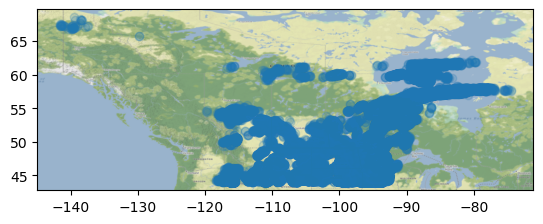

In [7]:
smol = get_ca_lt("20230530")
plot_ca(smol)

In [28]:
date_range = pd.date_range(start = "2023-05-01 12:00:00", end = "2023-06-14 00:00:00", freq="24H")

date_snap = date_range.strftime("%Y%m%d")
date_snap
nice_dates = date_range.strftime("%Y-%m-%d")

20230525


/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


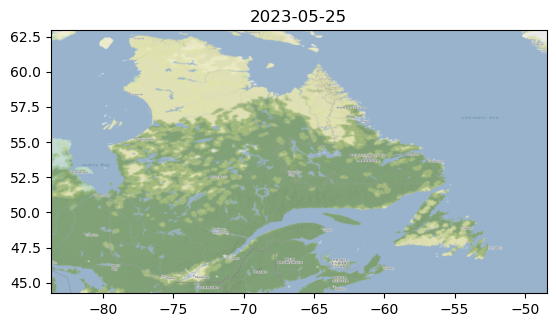

20230526


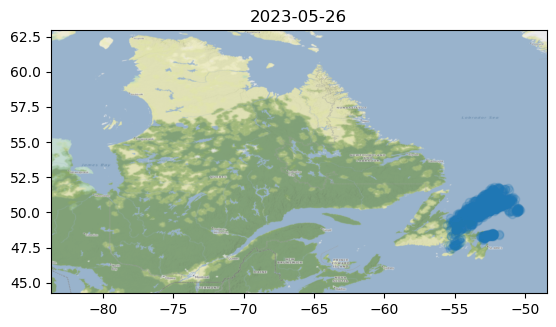

20230527


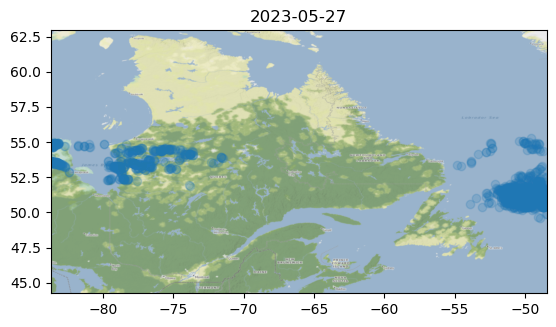

20230528


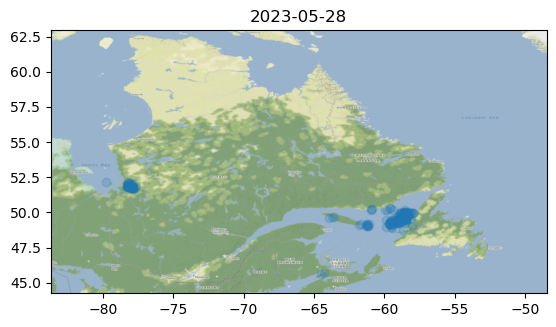

20230529


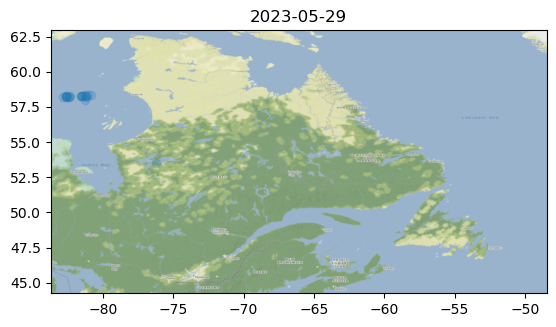

20230530


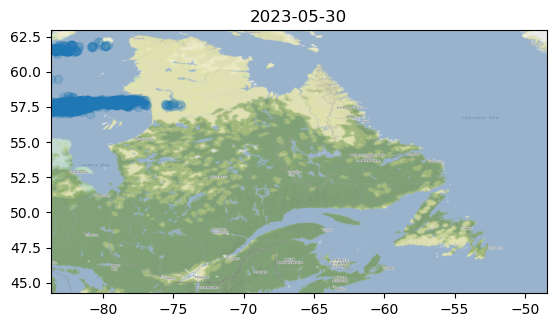

20230531


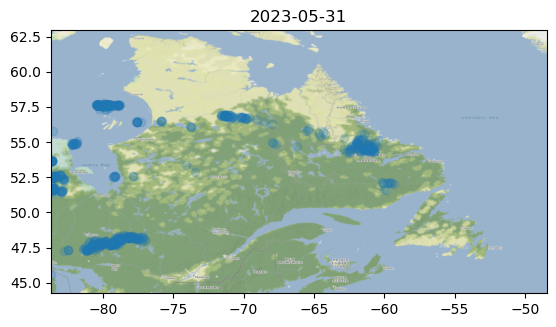

In [26]:
# for d,n in zip(date_snap,nice_dates) :
#     print(d)
#     bbox = [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
#     smol = get_ca_lt(str(d), bbox  = bbox)
#     plot_ca(smol, title = n, bbox = bbox)
    

In [38]:
## Make an overall lightning timing
import time
from datetime import date
import traceback



def lt_timeseries_extract(date_snap, region, sub_region, run_name): ## putting into function because might help memory???
    
    run_name = str(date.today()) + run_name_st
    lt = [] # full info per day
    bad_ids = [] # list of IDs that failed due to error
    bbox = [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
    for n,i in enumerate(date_snap, start = 0):

        try:
            smol = get_ca_lt(str(i), bbox = bbox )

        except Exception as e:
            print("Error at date: ",n,)
            bad_log = traceback.format_exc(limit = 40) # Get log of error
            print(bad_log)
            bad_ids.append(
            {
                "date": n, 
                "log": bad_log
            }
            )
        lt.append(smol)
        if((n%1 == 0) | (n == (len(date_range) -1))):
            print("")
            manyfr = gpd.GeoDataFrame(pd.concat(lt, ignore_index=True), crs= smol.crs)
            manyfr.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_" + region + "_" + sub_region +  "_" + run_name +".csv")
            debug = pd.DataFrame(bad_ids)
            debug.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/DEBUG_" + region + "_" + sub_region + "_" + run_name + ".csv")
        
    return(manyfr)

def lt_timeseries_extract_pq(date_snap, region, sub_region, run_name): ## putting into function because might help memory???
    
    run_name = str(date.today()) + run_name_st
    #lt = [] # full info per day
    bad_ids = [] # list of IDs that failed due to error
    bbox = [-169, 44, -48, 75]#[-83.69877641421793, 44.25483911637959, -55, 62.94135765648493] #[-169, 44, -48, 75] #[-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
    for n,i in enumerate(date_snap, start = 0):

        try:
            smol = get_ca_lt_parquet(str(i), bbox = bbox )

        except Exception as e:
            print("Error at date: ",n,)
            bad_log = traceback.format_exc(limit = 40) # Get log of error
            print(bad_log)
            bad_ids.append(
            {
                "date": n, 
                "log": bad_log
            }
            )
        #lt.append(smol)
        if((n%1 == 0) | (n == (len(date_range) -1))):
            print("")
            manyfr = gpd.GeoDataFrame(smol, crs= smol.crs)
            manyfr.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_" + region + "_" + sub_region +  "_" + run_name +i+".csv")
            debug = pd.DataFrame(bad_ids)
            debug.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/DEBUG_" + region + "_" + sub_region + "_" + run_name + i+".csv")
        
    return(manyfr)

In [4]:
import time
from datetime import date
import traceback



def lt_timeseries_extract_low_mem(date_snap, region, sub_region, run_name): ## putting into function because might help memory???
    
    run_name = str(date.today()) + run_name_st
    #lt = [] # full info per day
    bad_ids = [] # list of IDs that failed due to error
    bbox = [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
    for n,i in enumerate(date_snap, start = 0):

        try:
            smol = get_ca_lt(str(i), chunk_size = 1000, bbox = bbox )

        except Exception as e:
            print("Error at date: ",i,)
            bad_log = traceback.format_exc(limit = 40) # Get log of error
            print(bad_log)
            bad_ids.append(
            {
                "date": n, 
                "log": bad_log
            }
            )
        #lt.append(smol)
        if((n%1 == 0) | (n == (len(date_range) -1))):
            print("")
            manyfr = gpd.GeoDataFrame(smol, crs= smol.crs)
            manyfr.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_" + region + "_" + sub_region +  "_" + run_name +i+".csv")
            debug = pd.DataFrame(bad_ids)
            debug.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/DEBUG_" + region + "_" + sub_region + "_" + run_name + i+".csv")
            del manyfr
        


In [39]:
# 20230727
date_range = pd.date_range(start = "2023-04-01 00:00:00", end = "2023-09-13 00:00:00", freq="24H")

date_snap = date_range.strftime("%Y%m%d")
date_snap
nice_dates = date_range.strftime("%Y-%m-%d")

In [40]:
# Grab Currrent Time Before Running the Code
# start = time.time()

# ################# Horrible for loop ##################
# sub_region = "Boreal"
# region =  "CA"
# #year = "2023"
# run_name_st = "All_canada"
# manyfr = lt_timeseries_extract_pq(date_snap = date_snap, region = region,  sub_region = sub_region, run_name = run_name_st) ## putting into function because might help memory???

# # Grab Currrent Time After Running the Code
# end = time.time()

# #Subtract Start Time from The End Time
# total_time = end - start
# print("\n"+ str(total_time))

20230401

20230402

20230403

20230404

20230405

20230406

20230407

20230408

20230409

20230410

20230411
Error at date:  10
Traceback (most recent call last):
  File "/tmp/ipykernel_155/3789050772.py", line 48, in lt_timeseries_extract_pq
    smol = get_ca_lt_parquet(str(i), bbox = bbox )
  File "/tmp/ipykernel_155/3594157483.py", line 29, in get_ca_lt_parquet
    lt = pd.read_parquet("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/parrow_parquet/englnrt_"+ date+"_daily_v1_lit.parquet", columns =["InterCloud",
  File "/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/pandas/io/parquet.py", line 503, in read_parquet
    return impl.read(
  File "/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/pandas/io/parquet.py", line 244, in read
    path_or_handle, handles, kwargs["filesystem"] = _get_path_or_handle(
  File "/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/pandas/io/parquet.py", line 102, in _get_path_or_handle
    handles

In [31]:
#client.cancel()
#client.restart()
#client.close()
#client

In [4]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:40099")
# client

In [4]:
### Try to dask-parallelize this.

## Get dask client

In [ ]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:36779")
# client

In [5]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:38291")
# client


# from dask.distributed import Client, progress
# client = Client(threads_per_worker=2, n_workers=3)
# client

In [32]:
# import dask

# lazy_results = []

# for d in date_snap:
#     tmp = dask.delayed(get_ca_lt)(str(d))
#     lazy_results.append(tmp)

# futes = dask.persist(*lazy_results)  # trigger computation in the background

In [27]:
#client.cancel(futes)


In [6]:

# results = dask.compute(*futes)
# #results = dask.compute(*lazy_results)

In [30]:
#results
#date_snap

NameError: name 'results' is not defined

In [41]:
files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_*.csv")
files

['/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_2023-10-05base_stats.csv',
 '/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_2023-10-10One_at_a_time20230729.csv',
 '/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_2023-10-06One_at_a_time20230625.csv',
 '/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_2023-10-10One_at_a_time20230828.csv',
 '/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_2023-10-10One_at_a_time20230909.csv',
 '/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_2023-10-10One_at_a_time20230819.csv',
 '/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_2023-10-10One_at_a_time20230811.csv',
 '/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_2023-10-10One_at_a_time20230730.csv',
 '/projects/old_sha

In [21]:
def concat_subsets(files):
    df = []
    for f in files:
        manyfr = pd.read_csv(f)

        manyfr = gpd.GeoDataFrame(manyfr)

        manyfr.t = manyfr.t.astype("datetime64[ns]")
        df.append(manyfr)
    df = pd.concat(df)
    return(df)

#manyfr = pd.concat([manyfr, manyfr2])

manyfr= concat_subsets(files)
#manyfr = manyfr.drop_duplicates()

#manyfr2 = pd.read_csv('/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_2023-10-05base_stats_20230616.csv')

# manyfr = gpd.GeoDataFrame(manyfr)

# manyfr.t = manyfr.t.astype("datetime64[ns]")

In [22]:
manyfr.t.max()

Timestamp('2023-09-13 23:30:48.531000')

In [20]:
#n_strike = manyfr.groupby("t").count()

In [55]:
#manyfr = manyfr.sort_values( by = "t")

In [56]:
#print(manyfr.t.max())
#print(manyfr2.t.max())

2023-06-23 23:59:43.962000
2023-06-21 23:59:59.109


In [23]:
import time
from datetime import date

am = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
pm = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]



manyfr["day"] = manyfr.t.dt.day
manyfr["hour"] = manyfr.t.dt.hour
manyfr["is_am"] = manyfr.hour.isin(am)
manyfr["t_agg"] = manyfr.t.dt.strftime("%Y-%m-%d %H:00:00")
manyfr.t = manyfr.t.dt.tz_localize("UTC")


In [11]:
#manyfr.t.dt.tz_localize("UTC")

In [24]:
#n_strike.hour.unique()

In [24]:
day_strike = manyfr.groupby('t_agg').count()
#day_strike["t"] = day_strike.index
day_strike.index

Index(['2023-05-01 07:00:00', '2023-05-01 16:00:00', '2023-05-01 18:00:00',
       '2023-05-01 20:00:00', '2023-05-01 22:00:00', '2023-05-01 23:00:00',
       '2023-05-02 15:00:00', '2023-05-02 16:00:00', '2023-05-02 17:00:00',
       '2023-05-02 18:00:00',
       ...
       '2023-09-13 14:00:00', '2023-09-13 15:00:00', '2023-09-13 16:00:00',
       '2023-09-13 17:00:00', '2023-09-13 18:00:00', '2023-09-13 19:00:00',
       '2023-09-13 20:00:00', '2023-09-13 21:00:00', '2023-09-13 22:00:00',
       '2023-09-13 23:00:00'],
      dtype='object', name='t_agg', length=2061)

2023-06-15 23:00:00


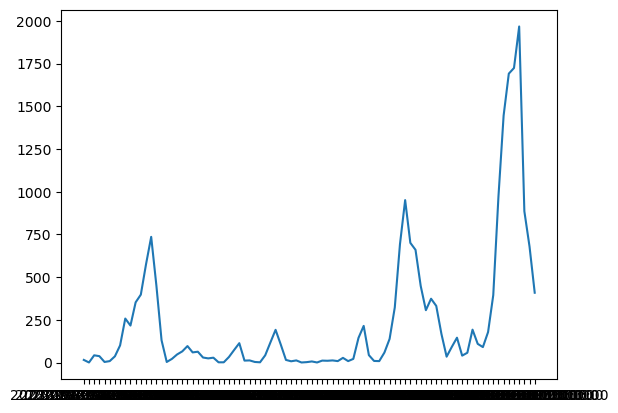

In [8]:
plt.plot(day_strike.index, day_strike.InterCloud)
print(max(day_strike.index))

In [25]:
### Get the station data

st = pd.read_csv("/projects/old_shared/Quebec_fwi_viz/718270-99999.linear.DailyFWIfromHourlyInterp.csv") ## Corrected record from Robert
#st = st[0:9672] # Cut out extra excel cells
st['HH'] = '12'
st.YYYY = st.YYYY.astype("int")
st.MM = st.MM.astype("int")
st.DD = st.DD.astype("int")
st = fv.date_convert(st)

st['MM_DD'] = st['time'].apply(lambda x: x.strftime('%m-%d'))

#st['ismayjune'] = np.logical_or((st.MM == 6), (st.MM == 5))
st['ismayjune'] = st.MM.isin([5, 6, 7]) # Is May, June or July? 
mj = st[st['ismayjune'] == True]
mj = mj.set_index("time")
#st = st.set_index("time")

mj = mj[mj.index > "1991-01-01 00:00:00"]
mj = mj[mj.index < "2020-12-31 23:00:00"]

#
mean_quant = mj.groupby([mj.index.day, mj.index.month]).mean()

dates = ("2023-" + mean_quant.index.get_level_values(level=1).astype("str") + "-" + mean_quant.index.get_level_values(level=0).astype("str"))

mean_quant["dates"] = pd.to_datetime(dates)
mean_quant = mean_quant.sort_values(by = "dates")
mean_quant.set_index("dates", inplace = True)


upper = mj.groupby([mj.index.day, mj.index.month]).quantile((1-0.025))
upper["dates"] = pd.to_datetime(dates)
upper = upper.sort_values(by = "dates")
upper.set_index("dates", inplace = True)

lower = mj.groupby([mj.index.day, mj.index.month]).quantile(0.025)
lower["dates"] = pd.to_datetime(dates)
lower = lower.sort_values(by = "dates")
lower.set_index("dates", inplace = True)


mid_lower = mj.groupby([mj.index.day, mj.index.month]).quantile(0.25)
mid_lower["dates"] = pd.to_datetime(dates)
mid_lower = mid_lower.sort_values(by = "dates")
mid_lower.set_index("dates", inplace = True)


mid_upper = mj.groupby([mj.index.day, mj.index.month]).quantile(0.75)
mid_upper["dates"] = pd.to_datetime(dates)
mid_upper = mid_upper.sort_values(by = "dates")
mid_upper.set_index("dates", inplace = True)


date_range = pd.date_range(start = "2023-05-01 12:00:00", end = "2023-07-01 12:00:00", freq="12H")
#date_range_format = datetime.strptime(date_rage, 
date_snap = date_range.strftime("%Y%m%d%p")
date_snap
nice_dates = date_range.strftime("%Y-%m-%d %p")

/tmp/ipykernel_155/2041920695.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_quant = mj.groupby([mj.index.day, mj.index.month]).mean()
/tmp/ipykernel_155/2041920695.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upper = mj.groupby([mj.index.day, mj.index.month]).quantile((1-0.025))
/tmp/ipykernel_155/2041920695.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  lower = mj.groupby([mj.index.d

In [19]:
#### To generate fire stats
# snap_list = []
# for d,n in zip(date_snap, date_range):
#     #print(n)
#     snap = fv.prep_gdf(date = d,layer='perimeter',handle_multi=False,only_lf=False,area_lim=3.7, year = "2023", path_region = "QuebecGlobalNRT_tess")
#     farea = sum(snap.farea)
#     numfires = len(snap.mergeid.unique())
#     num_active_fires = len(snap[snap.n_newpixels > 0])
#     tot_frp = sum(snap.meanFRP)
#     mean_frp = snap.meanFRP.mean()
    
#     snap_list.append([n, farea, numfires, num_active_fires, tot_frp, mean_frp])
    

#     #snap = snap[snap.t ]
# fire_stats = pd.DataFrame(data = snap_list, columns = ["t", "farea", "numfires", "num_active_fires",  "tot_frp", "mean_frp"])
# fire_stats.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/exp_Quebec_firestats.csv")

/tmp/ipykernel_3705/2969434469.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_quant = mj.groupby([mj.index.day, mj.index.month]).mean()
/tmp/ipykernel_3705/2969434469.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upper = mj.groupby([mj.index.day, mj.index.month]).quantile((1-0.025))
/tmp/ipykernel_3705/2969434469.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  lower = mj.groupby([mj.inde

In [12]:
fire_stats = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Quebec_firestats.csv")

In [13]:
fire_stats.t = fire_stats.t.astype("datetime64[ns]").dt.tz_localize("UTC")
#fire_stats

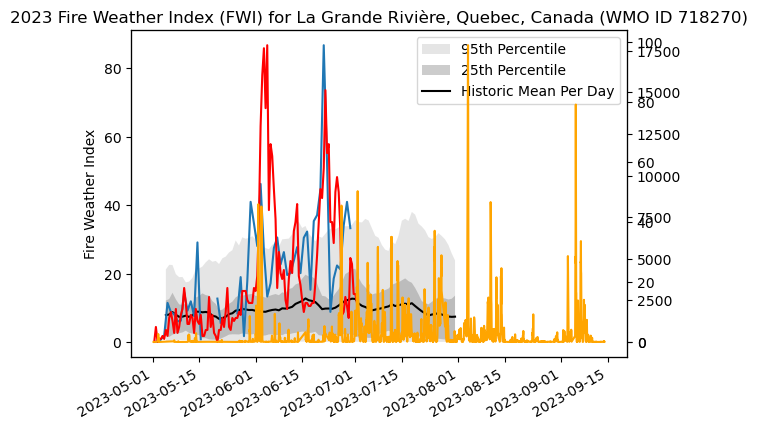

In [26]:
#plt.plot(day_strike.index, day_strike.InterCloud)
fig, ax = plt.subplots()
ax.fill_between(upper.index, upper.FWI.rolling(5).mean(), lower.FWI.rolling(5).mean(), 
                facecolor='grey', 
                alpha=0.2,
                label= "95th Percentile")
ax.fill_between(mid_upper.index, mid_upper.FWI.rolling(5).mean(), mid_lower.FWI.rolling(5).mean(), 
                facecolor='grey', 
                alpha=0.4,
                label= "25th Percentile")
ax.plot(mean_quant.index, mean_quant.FWI.rolling(5).mean(), 
        color = "black",
        label= "Historic Mean Per Day")
ax.plot(st[(st.time >= "2023-05-01")].time.astype('datetime64[ns]'), st[(st.time >= "2023-05-01")].FWI)
ax.set_ylabel("Fire Weather Index")
ax.set_title("2023 Fire Weather Index (FWI) for La Grande Rivière, Quebec, Canada (WMO ID 718270)")
ax.legend()
ax2 = ax.twinx()
ax2.plot(fire_stats.t, fire_stats.num_active_fires, color = "red", label = "Number of Fires in Quebec")
#ax2.legend(loc = 0.5)
ax3 = ax.twinx()
ax3.plot(day_strike.index.astype("datetime64[ns]"), day_strike.InterCloud, color = "orange")
fig.autofmt_xdate()

#plt.plot(day_strike.index, day_strike.InterCloud)

In [20]:
max(day_strike.index.astype("datetime64[ns]"))

Timestamp('2023-06-08 23:00:00')

In [78]:
day_strike.index.astype("datetime64[ns]")

DatetimeIndex(['2023-05-01 07:00:00', '2023-05-01 16:00:00',
               '2023-05-01 18:00:00', '2023-05-01 20:00:00',
               '2023-05-01 22:00:00', '2023-05-01 23:00:00',
               '2023-05-02 15:00:00', '2023-05-02 16:00:00',
               '2023-05-02 17:00:00', '2023-05-02 18:00:00',
               '2023-05-02 19:00:00', '2023-05-02 20:00:00',
               '2023-05-02 21:00:00', '2023-05-02 22:00:00',
               '2023-05-02 23:00:00', '2023-05-03 00:00:00',
               '2023-05-03 02:00:00', '2023-05-07 11:00:00',
               '2023-05-07 12:00:00', '2023-05-07 13:00:00',
               '2023-05-07 22:00:00', '2023-05-09 04:00:00',
               '2023-05-11 13:00:00', '2023-05-11 14:00:00',
               '2023-05-11 15:00:00', '2023-05-11 17:00:00',
               '2023-05-11 18:00:00', '2023-05-11 19:00:00',
               '2023-05-11 20:00:00', '2023-05-11 21:00:00',
               '2023-05-11 22:00:00', '2023-05-11 23:00:00',
               '2023-05-

In [52]:
from matplotlib import pyplot as plt

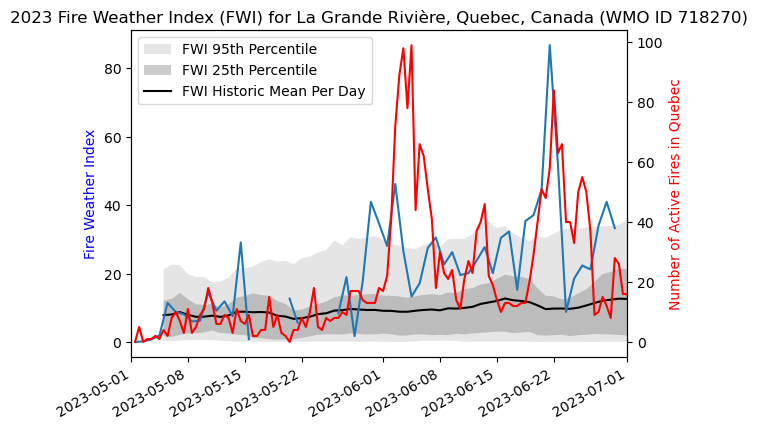

In [55]:
#plt.plot(day_strike.index, day_strike.InterCloud)
#plt.style.use('dark_background')
#plt.style.use('fast')
#plt.style.use('Solarized_Light')

fig, ax = plt.subplots()
ax.fill_between(upper.index, upper.FWI.rolling(5).mean(), lower.FWI.rolling(5).mean(), 
                facecolor='grey', 
                alpha=0.2,
                label= "FWI 95th Percentile")
ax.fill_between(mid_upper.index, mid_upper.FWI.rolling(5).mean(), mid_lower.FWI.rolling(5).mean(), 
                facecolor='grey', 
                alpha=0.4,
                label= "FWI 25th Percentile")
ax.plot(mean_quant.index, mean_quant.FWI.rolling(5).mean(), 
        color = "black",
        label= "FWI Historic Mean Per Day")
ax.plot(st[(st.time >= "2023-05-01")].time.astype('datetime64[ns]'), st[(st.time >= "2023-05-01")].FWI)
ax.set_ylabel("Fire Weather Index", color = "blue")
ax.set_title("2023 Fire Weather Index (FWI) for La Grande Rivière, Quebec, Canada (WMO ID 718270)")
ax.legend()
ax.set_xlim(datetime.date(2023, 5, 1), datetime.date(2023, 7, 1))
ax2 = ax.twinx()
ax2.plot(fire_stats.t.astype("datetime64[ns]"), fire_stats.num_active_fires, color = "red", label = "Number of Fires in Quebec")
ax2.set_ylabel("Number of Active Fires in Quebec", color = "Red")
#ax2.legend(loc = 0.5)
#ax3 = ax.twinx()
#ax3.plot(day_strike.index.astype("datetime64[ns]"), day_strike.InterCloud, color = "orange")

fig.autofmt_xdate()
#fig.show()
plt.show()